In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn import metrics
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
import statsmodels.api as sm

In [2]:
pd.set_option("display.max_rows",50)
df=pd.read_csv('Phishing_Legitimate_full.csv')

#koniecznie usuwamy id bo przypisuje do tej kolumny predykcje, anstenie model ma metryki 1
df.drop(['id'],axis=1,inplace=True)

In [3]:
#podział zmiennych w modelu na numeryczne i kateogryczne 
target = 'CLASS_LABEL'
numFeatures = ['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'NumUnderscore','NumPercent', 'NumQueryComponents', 'NumAmpersand',
       'NumNumericChars','HostnameLength', 'PathLength', 'QueryLength',
       'NumSensitiveWords']
catFeatures = ['AtSymbol','TildeSymbol','NumHash', 'NoHttps','RandomString', 'IpAddress','DomainInSubdomains','DomainInPaths','HttpsInHostname',
              'DoubleSlashInPath','EmbeddedBrandName','PctExtHyperlinks','PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm','ExtMetaScriptLinkRT','UrlLengthRT','SubdomainLevelRT',
       'PctExtResourceUrlsRT', 'AbnormalExtFormActionR',
       'PctExtNullSelfRedirectHyperlinksRT']

In [4]:
# one hot encoding
dummLev = pd.get_dummies(df[catFeatures], drop_first=True)
df = pd.concat([df[numFeatures], dummLev, df[[target]]], axis=1)

In [5]:
features = df.columns.tolist()
features.remove(target)
print(features)

['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'NumUnderscore', 'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumNumericChars', 'HostnameLength', 'PathLength', 'QueryLength', 'NumSensitiveWords', 'AtSymbol', 'TildeSymbol', 'NumHash', 'NoHttps', 'RandomString', 'IpAddress', 'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname', 'DoubleSlashInPath', 'EmbeddedBrandName', 'PctExtHyperlinks', 'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms', 'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction', 'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch', 'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow', 'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle', 'ImagesOnlyInForm', 'ExtMetaScriptLinkRT', 'UrlLengthRT', 'SubdomainLevelRT', 'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'PctExtNullSelfRedirectHyperlinksRT']


In [6]:
#wrapper walidacji krzyżowej dla algorytmu Gaussian Naive Bayes
def CVTestNBGaussian(nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Lista z wynikami
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = GaussianNB(*args, **kwargs)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie ROC-AUC dla foldów
        trainScore = roc_auc_score((df[target].iloc[train]==1), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]==1), preds)
        
        # Zapisanie wyników dla foldów
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [7]:
#trenowanie modelu algorytmem Naive Bayes
trainResults, testResults, predictions, indices = CVTestNBGaussian(debug=True)
print(np.mean(testResults))

GaussianNB()
Train AUC: 0.9461602226105008 Valid AUC: 0.9465980775307911
GaussianNB()
Train AUC: 0.9462892080764995 Valid AUC: 0.9419381700009707
GaussianNB()
Train AUC: 0.9442639053360207 Valid AUC: 0.9526926681061166
GaussianNB()
Train AUC: 0.9474976015135295 Valid AUC: 0.9377637986403387
GaussianNB()
Train AUC: 0.9458037278183247 Valid AUC: 0.9464331608290208
0.9450851750214475


In [8]:
#zapisanie modelu z użyciem Naive Bayes - narazie najgorszy model
modelNB = {
    "name":"NB",
    "description":"Prosty model Naive Bayes",
    "specification":'',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

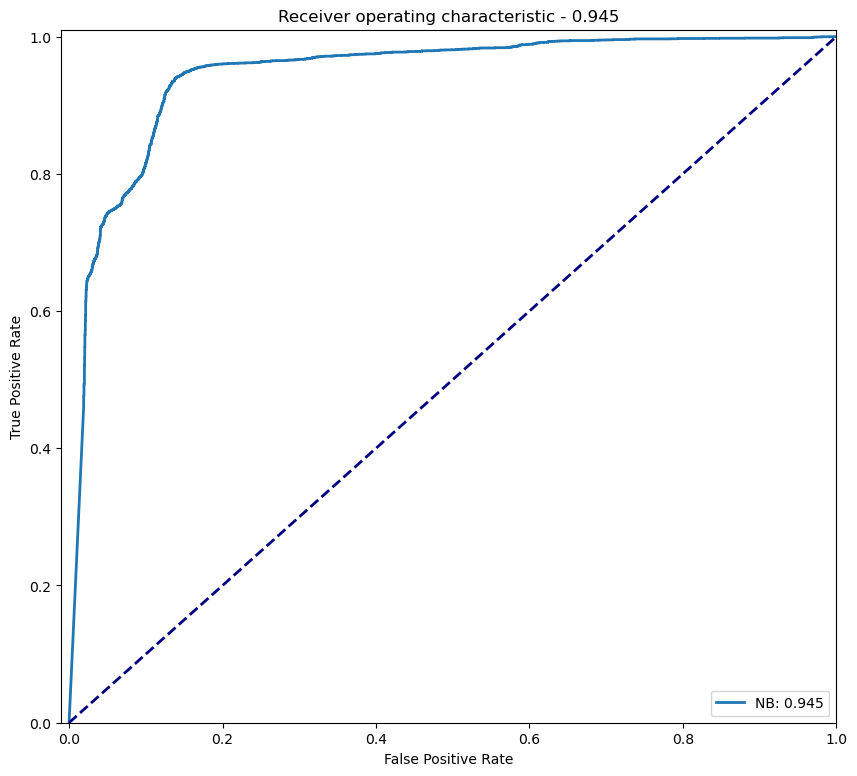

In [9]:
def plotROCs(results):
    ''' Funkcja, do rysowania szeregu wyników krzywych ROC dla poszczególnych eksperymentów
    results - lista wyników jako 3 elementowe tuple (true, pred, label)
    '''

    # Ustalanie wielkości rysunku
    fig, ax = plt.subplots(figsize=(10,9))

    for true, pred, label in results:
        # Obliczenie punktów potrzebnych do narysowani akrzywej ROC
        # funkcja roc_curve zwarca trzy serie danych, fpr, tpr oraz poziomy progów odcięcia
        fpr, tpr, thresholds = roc_curve(true, pred)
        # Obliczamy pole powierzchni pod krzywą
        rocScore = roc_auc_score(true, pred)
        rocScore = round(rocScore, 3)

        # Grubość krzywej
        lw = 2

        # Rysujemy krzywą ROC
        ax.plot(fpr, tpr, lw=lw, label=f'{label}: {rocScore}')
    # Rysujemy krzywą 45 stopni jako punkt odniesienia
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    # Dodajemy lekkie marginesy do zakresu aby krzywa nie pokrywała się z osiami
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {rocScore}')
    ax.legend(loc="lower right")
    plt.show()

res2plot = []
true = (df[target]==1).sort_index()
pred = pd.Series(sum(modelNB["predictions"], []), index=sum(modelNB["indices"], [])).sort_index()
res2plot.append((true, pred, modelNB["name"]))

plotROCs(res2plot)